In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import os
pd.options.mode.chained_assignment = None
from typing import List, Tuple

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN
import torch
import torch.nn as nn
from torchinfo import summary

In [2]:
class WellCorrelationDataset:
    
    def __init__(self, 
                 root : str = '../data/',
                 train_preload : bool = True,
                 test_preload : bool = False,
                 fill_na_method : str = None):
        self.root : str = root
        self.train_path : str = os.path.join(self.root, 'train.csv')
        self.test_path : str = os.path.join(self.root, 'test.csv')
        self.train_preload : bool = train_preload
        self.test_preload : bool = test_preload
        self.fill_na_method : str = fill_na_method
        self.train_data : pd.DataFrame = None
        self.test_data : pd.DataFrame = None
        self.wells_list = None
        self.target_groups = None
        self.group_num_map = {}
        self.used_cols = ['WELL', 'Z_LOC', 'GR', 'DTC', 'GROUP']

        self.__preload__()
        
    def __preload__(self):
        if self.train_preload:
            self.train_data = pd.read_csv(self.train_path, delimiter=';')
            self.train_data.loc[:, 'Z_LOC'] *= -1
            self.train_data.sort_values(by = ['WELL', 'Z_LOC'])
            self.wells_list = self.train_data.WELL.unique()
            self.target_groups = self.train_data.GROUP.unique()
            for i, label in enumerate(self.target_groups):
                self.group_num_map.update({label : i})
            self.train_data.loc[:, 'GROUP_NUM'] = self.train_data.GROUP.map(self.group_num_map)
            self.used_cols += ['GROUP_NUM']
        
        if self.test_preload:
            self.test_preload = pd.read_csv(self.test_path, delimiter=';')
    
    def get_well(self, idx : str, process_na:bool = True):
        assert(idx in self.wells_list)
        well_df = self.train_data.loc[self.train_data.WELL == idx, self.used_cols]
        if process_na:
            if self.fill_na_method is None:
                well_df.fillna(0., inplace = True)
            else:
                assert(self.fill_na_method in ['ffill', 'bfill', 'pad'])
                well_df.fillna(method = self.fill_na_method, inplace = True)

#             well_df.dropna(inplace = True)
        return well_df
    
    def get_matching_wells_id(self, tmpt : str = ""):
        m_wells = []
        for w in self.wells_list:
            m_wells += [w] if tmpt in w else []
        return m_wells
    
    def show_wells_info(self, idx : str = ""):
        df = self.get_well(idx)
        

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncoderDecoder1DCNN(2, 50, norm_layer=None, activation=nn.SELU)
model.to(device)
model.load_state_dict(torch.load('./modelstate_vr_loss_l2_dominated'))
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

In [4]:
summary(model.encoder, (10, 2, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv1d: 1-1                            [10, 5, 109]              105
├─SELU: 1-2                              [10, 5, 109]              --
├─Conv1d: 1-3                            [10, 10, 118]             510
├─SELU: 1-4                              [10, 10, 118]             --
├─Conv1d: 1-5                            [10, 10, 127]             1,010
├─SELU: 1-6                              [10, 10, 127]             --
├─Conv1d: 1-7                            [10, 10, 136]             1,010
├─SELU: 1-8                              [10, 10, 136]             --
├─Conv1d: 1-9                            [10, 1, 145]              101
├─SELU: 1-10                             [10, 1, 145]              --
├─Linear: 1-11                           [10, 1, 50]               7,300
Total params: 10,036
Trainable params: 10,036
Non-trainable params: 0
Tot

In [49]:
def get_window(df : pd.DataFrame, 
               w_size : int = 10, 
               cols : List[str] = ['DTC', 'GR'],
              n_template_per_group = 10) -> Tuple[np.ndarray, List[np.ndarray]]:
    template = []
    group_seq = df.loc[:, 'GROUP_NUM'].values
    
    diff = np.zeros(group_seq.shape)
    diff[1:] = group_seq[1:] - group_seq[:-1]
    
    idx = np.where(diff != 0)[0]
    idx = np.append([0], idx)
    
    cols = [i if col in cols else None for i, col in enumerate(df.columns)]
    
    tmp_ = []
    for col in cols:
        if col is not None:
            tmp_ += [col]
            
    cols = tmp_
    
    for i in range(1, len(idx)):
        w_list = np.zeros((n_template_per_group, w_size, len(cols)), dtype = np.float32)
        
        for n in range(n_template_per_group):
            left_idx, right_idx = idx[i-1], idx[i]-w_size
            right_idx = idx[i] if right_idx <= left_idx else right_idx
            
            idx_lim = np.random.randint(left_idx, right_idx, 1)[0]
            left_lim, right_lim = max(0, idx_lim), min(idx_lim+w_size, diff.shape[0])
            
            w_list[n, :, :] = df.iloc[left_lim:right_lim, cols].values
        
        template += [w_list]
    
    return idx, template

In [95]:
def match(target_df, template, cols = [2, 3]):
    correlation_vals = []
    
    n = target_df.shape[0]
    
    feature_seq = np.float32(target_df.iloc[:, cols].values)
    feature_seq = np.pad(feature_seq, template.shape[1], mode='constant', constant_values = 0)
    
    template_emb = model.encoder(template).squeeze(dim=-1)
    template_emb = template_emb.detach().cpu().numpy()
    template_emb /= np.linalg.norm(template_emb, axis=-1, keepdims=True)
    
    left_offset, right_offset = 0, template.shape[-1]
    
    for k in range(left_offset, n-right_offset):
        local_patch = np.float32(feature_seq[k-left_offset:k+right_offset, cols]).T
        local_patch /= np.linalg.norm(local_patch, axis=1, keepdims=True)+0.000001
        local_patch /= np.linalg.norm(local_patch, axis=0, keepdims=True)+0.000001
        local_patch = torch.from_numpy(local_patch).unsqueeze(dim=0)
        local_patch = local_patch.to(device)
        if (local_patch.shape[1:] != template.shape[1:]):
            print(f'Found local patch mismatch {k}, {local_patch.shape}, {k-template.shape[-1]//2, k + template.shape[-1]//2}')
            continue
        local_patch_embed = model.encoder(local_patch).squeeze(dim=0)
        local_patch_embed = local_patch_embed.detach().cpu().numpy()
        local_patch_embed /= np.linalg.norm(local_patch_embed, axis=-1, keepdims=True)
        
        correlation_vals += [template_emb.dot(local_patch_embed.T).squeeze(axis=-1).squeeze(axis=-1).mean(axis=-1)]
    
    return np.array(correlation_vals, dtype=np.float32)

In [81]:
dataset = WellCorrelationDataset(fill_na_method=None)

In [96]:
print(dataset.group_num_map)
inv_group_num_map = {}
for key, val in dataset.group_num_map.items():
    inv_group_num_map.update({val: key})
print(inv_group_num_map)

{'NORDLAND GP.': 0, 'HORDALAND GP.': 1, 'ROGALAND GP.': 2, 'SHETLAND GP.': 3, 'CROMER KNOLL GP.': 4, 'VIKING GP.': 5, 'VESTLAND GP.': 6, 'ZECHSTEIN GP.': 7, 'HEGRE GP.': 8, 'ROTLIEGENDES GP.': 9, 'TYNE GP.': 10, 'BOKNFJORD GP.': 11, 'DUNLIN GP.': 12, 'BAAT GP.': 13, nan: 14}
{0: 'NORDLAND GP.', 1: 'HORDALAND GP.', 2: 'ROGALAND GP.', 3: 'SHETLAND GP.', 4: 'CROMER KNOLL GP.', 5: 'VIKING GP.', 6: 'VESTLAND GP.', 7: 'ZECHSTEIN GP.', 8: 'HEGRE GP.', 9: 'ROTLIEGENDES GP.', 10: 'TYNE GP.', 11: 'BOKNFJORD GP.', 12: 'DUNLIN GP.', 13: 'BAAT GP.', 14: nan}


In [97]:
dataset.wells_list

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [98]:
matching_wells = dataset.get_matching_wells_id("31/2")
print(f'matching wells ids : {matching_wells}')

matching wells ids : ['31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9']


In [141]:
def get_matching_results(matching_wells, asymmetric=False):
    df_w1_reference = dataset.get_well(matching_wells[0])
    idx, templates = get_window(df_w1_reference, 100)
    
    result = []
    for idx_, group_num, template in zip(idx, df_w1_reference.iloc[idx].GROUP_NUM.values, templates):
        # Define target template
        target_template = np.float32(template).transpose((0, 2, 1))
        target_template /= np.linalg.norm(target_template, axis=2, keepdims=True)+0.000001
        target_template /= np.linalg.norm(target_template, axis=1, keepdims=True)+0.000001
        target_template = torch.from_numpy(target_template)
        target_template = target_template.to(device)

        for well in matching_wells[1:]:
            source_df = dataset.get_well(well)

            correlation_vals = match(source_df, target_template)
            
            mean_corr, std_corr = correlation_vals[100:-100].mean(), correlation_vals[100:-100].std()
            thresh = mean_corr+1.2*std_corr
            
            print(f'max corr : {correlation_vals.max()}, threshold : {thresh}')
            
            matching_results = np.zeros((2, len(correlation_vals)))
            matching_results[0, np.where(correlation_vals >= thresh)] = 1.
            
            group_nums = np.float32(source_df.GROUP_NUM.values)
#             matching_results[1, :][(group_nums == group_num)[100:]] = 1.
            
            plt.plot(matching_results.T)
            plt.show()
            
            result += [['31/2-1', well, group_num]]
#             print(f'Target well : 31/2-1, {group_num}, \nSource well : {well, source_idx, group_nums}, \nmatching target loc: {matching_z_val} vs {gt_matching_loc}')
            print('\n------------------------------------------------------')
            print('------------------------------------------------------\n')
    return result

matching wells ids : ['31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9']
max corr : 0.9568122029304504, threshold : 0.9602120995521546


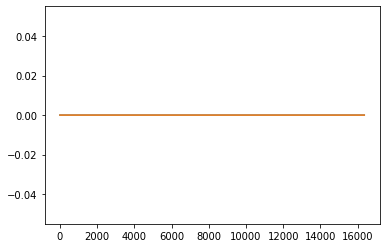


------------------------------------------------------
------------------------------------------------------

max corr : 0.9515970349311829, threshold : 1.1861541509628295


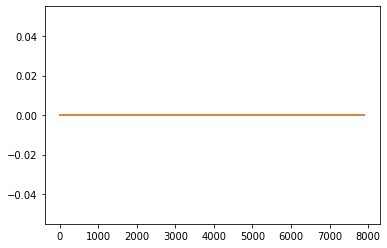


------------------------------------------------------
------------------------------------------------------

max corr : 0.9508110284805298, threshold : 0.9613606601953506


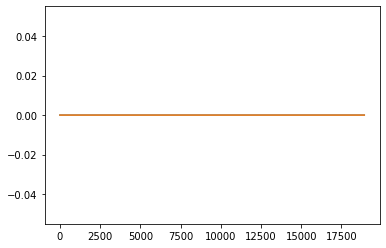


------------------------------------------------------
------------------------------------------------------

max corr : 0.952479362487793, threshold : 0.9665773749351502


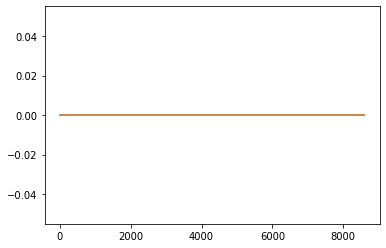


------------------------------------------------------
------------------------------------------------------

max corr : 0.9089757800102234, threshold : 0.9219151049852371


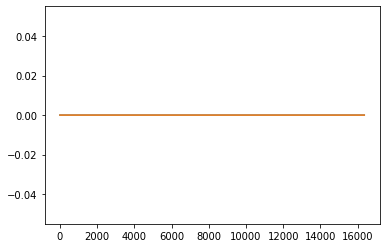


------------------------------------------------------
------------------------------------------------------

max corr : 0.907760500907898, threshold : 1.142971110343933


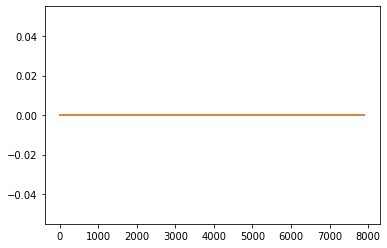


------------------------------------------------------
------------------------------------------------------



KeyboardInterrupt: 

In [142]:
matching_wells = dataset.get_matching_wells_id("31/2")
print(f'matching wells ids : {matching_wells}')
results = get_matching_results(matching_wells)
results = pd.DataFrame(results, columns=['Target Well', 'Matching Well', 'Group Num', 'Matching depth', 'Actual Depth'])
results.loc[:, 'Group Num'] = results.loc[:, 'Group Num'].map(inv_group_num_map)
results = results.sort_values(by = ['Matching Well', 'Target Well', 'Group Num'])
results.to_csv('Target_Well_31_2.csv', index=False)

matching wells ids : ['15/9-13', '15/9-15', '15/9-17']
max corr : 0.9223173260688782, threshold : 0.8196773007512093


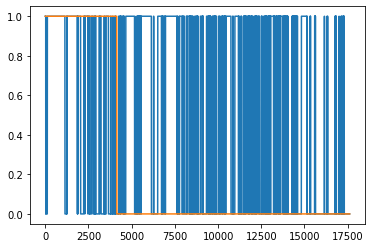


------------------------------------------------------
------------------------------------------------------

max corr : 0.9234039187431335, threshold : 0.8431323677301407


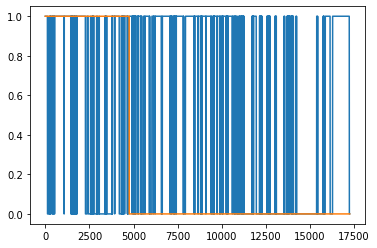


------------------------------------------------------
------------------------------------------------------

max corr : 0.9419762492179871, threshold : 0.8408546864986419


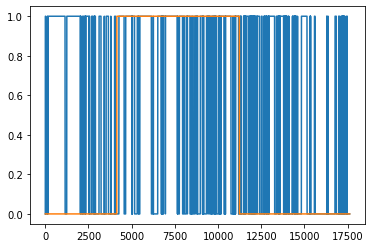


------------------------------------------------------
------------------------------------------------------

max corr : 0.9456707239151001, threshold : 0.8652506381273269


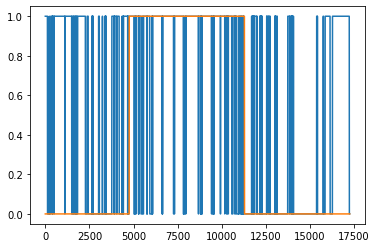


------------------------------------------------------
------------------------------------------------------

max corr : 0.8666394948959351, threshold : 0.7737336531281471


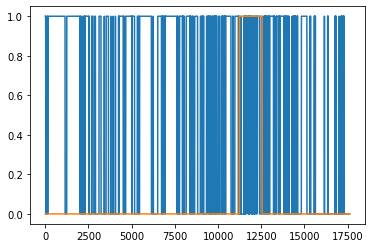


------------------------------------------------------
------------------------------------------------------

max corr : 0.8715304136276245, threshold : 0.7957847416400909


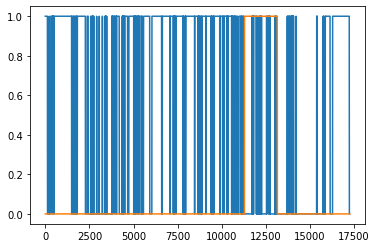


------------------------------------------------------
------------------------------------------------------

max corr : 0.861622154712677, threshold : 0.7663712918758392


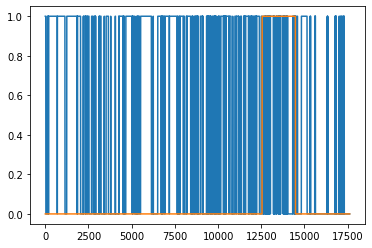


------------------------------------------------------
------------------------------------------------------

max corr : 0.8637163043022156, threshold : 0.7877548843622207


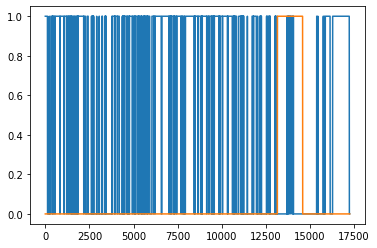


------------------------------------------------------
------------------------------------------------------

max corr : 0.8480620384216309, threshold : 0.7548472657799721


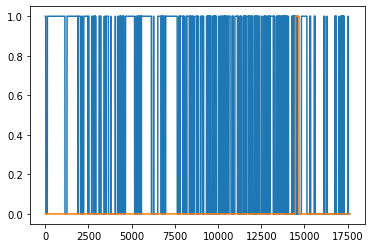


------------------------------------------------------
------------------------------------------------------

max corr : 0.8508231043815613, threshold : 0.7768501967191697


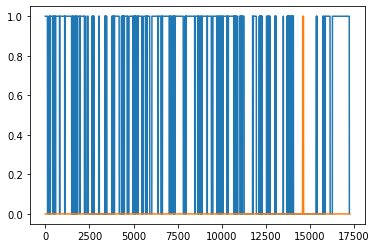


------------------------------------------------------
------------------------------------------------------

max corr : 0.8925784826278687, threshold : 0.7892146870493889


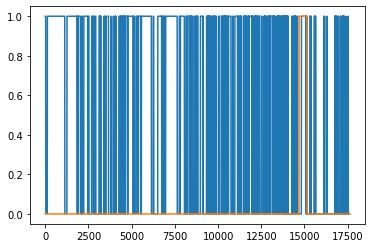


------------------------------------------------------
------------------------------------------------------



KeyboardInterrupt: 

In [140]:
matching_wells = dataset.get_matching_wells_id("15/9")
print(f'matching wells ids : {matching_wells}')
results = get_matching_results(matching_wells)
results = pd.DataFrame(results, columns=['Target Well', 'Matching Well', 'Group Num', 'Matching depth', 'Actual Depth'])
results.loc[:, 'Group Num'] = results.loc[:, 'Group Num'].map(inv_group_num_map)
results = results.sort_values(by = ['Matching Well', 'Target Well', 'Group Num'])
results.to_csv('Target_Well_15_9.csv', index=False)

matching wells ids : ['16/10-1', '16/10-2', '16/10-3', '16/10-5']
correlation shape : (2337,)
Target well : 31/2-1, 1, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


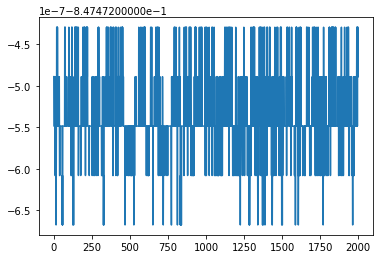

Target well : 31/2-1, 1, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 972.7422485 vs 978.0622559

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 1, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)
Target well : 31/2-1, 2, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


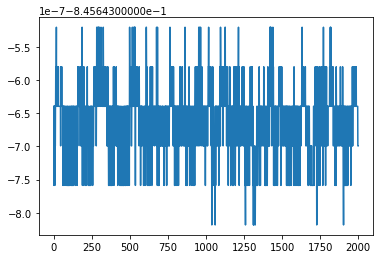

Target well : 31/2-1, 2, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 1791.041992 vs 1788.914551

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 2, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)
Target well : 31/2-1, 3, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


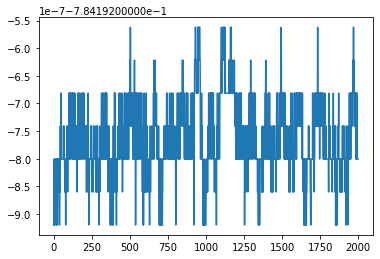

Target well : 31/2-1, 3, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 1991.405029 vs 1988.823975

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 3, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)


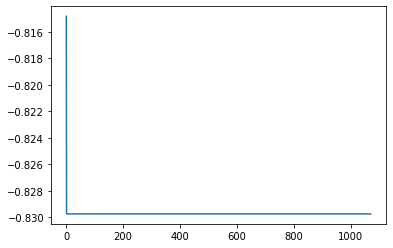

Target well : 31/2-1, 4, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: 2748.705078 vs 2750.83252

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


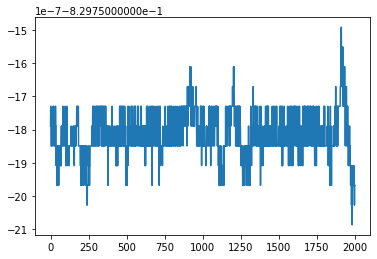

Target well : 31/2-1, 4, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2320.217773 vs 2320.673584

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)


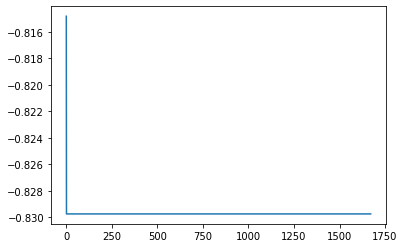

Target well : 31/2-1, 4, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: 2704.694092 vs 2665.637695

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)


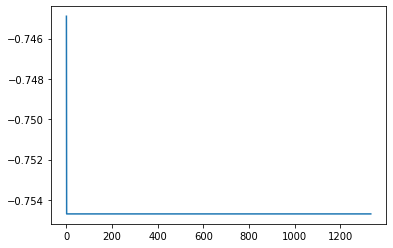

Target well : 31/2-1, 5, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: 2788.970459 vs 2790.793701

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


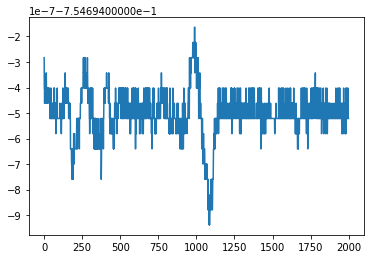

Target well : 31/2-1, 5, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2460.609375 vs 2460.609375

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 5, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)


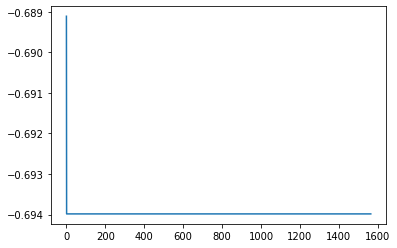

Target well : 31/2-1, 6, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: 2822.09375 vs 2825.892578

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


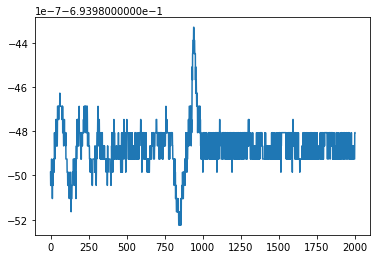

Target well : 31/2-1, 6, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2478.232666 vs 2480.66333

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)


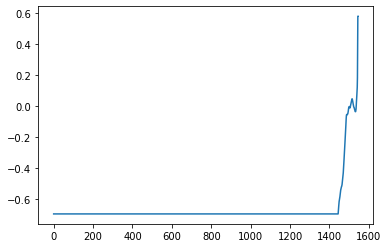

Target well : 31/2-1, 6, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: 2880.165527 vs 2885.481689

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)
Target well : 31/2-1, 7, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)
Target well : 31/2-1, 7, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 7, 
Source well : ('16/1

In [21]:
matching_wells = dataset.get_matching_wells_id("16/10")
print(f'matching wells ids : {matching_wells}')
results = get_matching_results(matching_wells)
results = pd.DataFrame(results, columns=['Target Well', 'Matching Well', 'Group Num', 'Matching depth', 'Actual Depth'])
results.loc[:, 'Group Num'] = results.loc[:, 'Group Num'].map(inv_group_num_map)
results = results.sort_values(by = ['Matching Well', 'Target Well', 'Group Num'])
results.to_csv('Target_Well_16_10.csv', index=False)

matching wells ids : ['16/2-11 A', '16/2-16', '16/2-6']
correlation shape : (9925,)


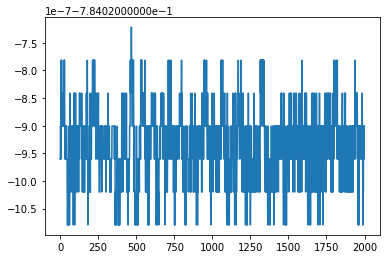

Target well : 31/2-1, 1, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 959.9296875 vs 965.7056885

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


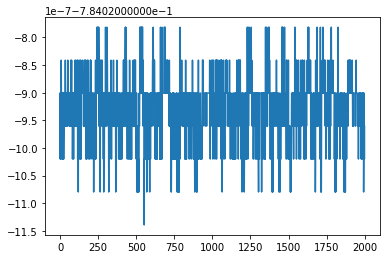

Target well : 31/2-1, 1, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 717.6565552 vs 912.9684448

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


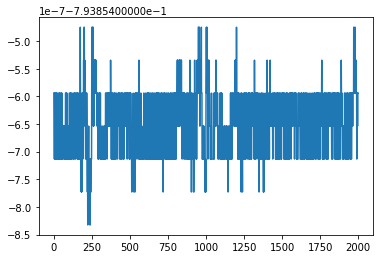

Target well : 31/2-1, 2, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1479.009399 vs 1478.705444

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


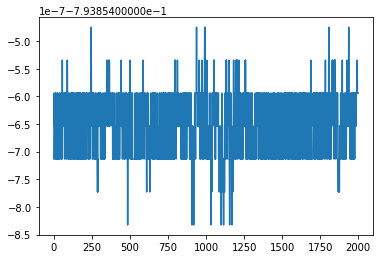

Target well : 31/2-1, 2, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1327.46167 vs 1442.064453

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


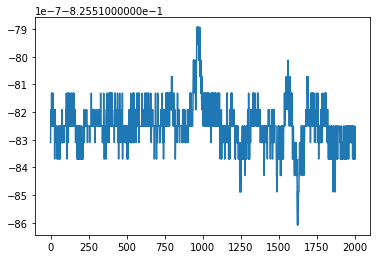

Target well : 31/2-1, 3, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1658.673584 vs 1658.673584

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


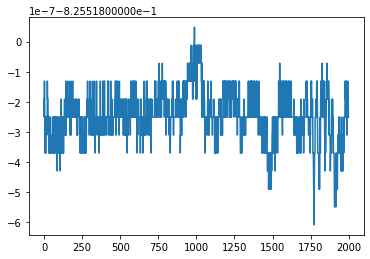

Target well : 31/2-1, 3, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1602.572388 vs 1601.964355

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


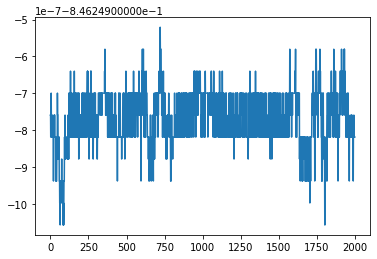

Target well : 31/2-1, 4, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1795.321533 vs 1797.75354

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


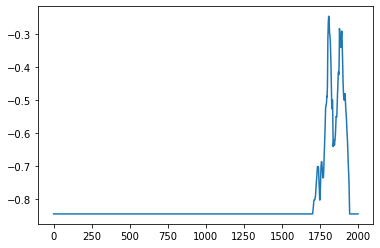

Target well : 31/2-1, 4, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1776.457886 vs 1779.041748

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


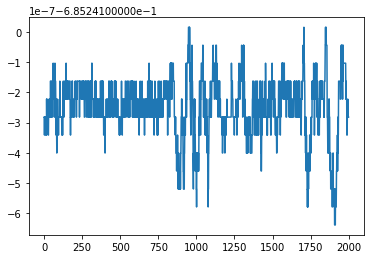

Target well : 31/2-1, 5, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1915.24939 vs 1919.657227

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


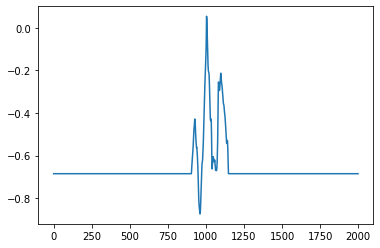

Target well : 31/2-1, 5, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1900.025635 vs 1900.025635

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


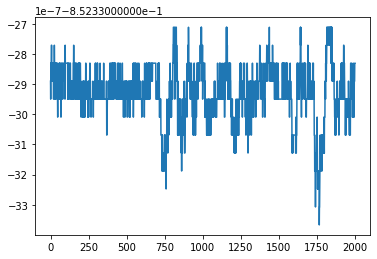

Target well : 31/2-1, 6, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1937.441284 vs 1937.745239

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


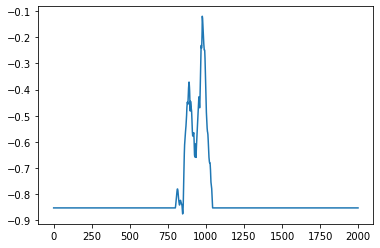

Target well : 31/2-1, 6, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1915.984619 vs 1915.984619

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


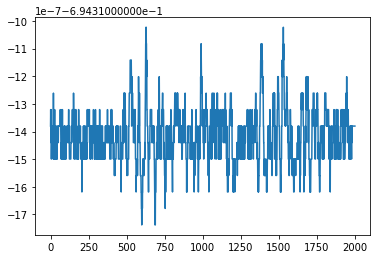

Target well : 31/2-1, 8, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1972.097046 vs 1972.705078

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)
Target well : 31/2-1, 8, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------



In [22]:
matching_wells = dataset.get_matching_wells_id("16/2")
print(f'matching wells ids : {matching_wells}')
results = get_matching_results(matching_wells)
results = pd.DataFrame(results, columns=['Target Well', 'Matching Well', 'Group Num', 'Matching depth', 'Actual Depth'])
results.loc[:, 'Group Num'] = results.loc[:, 'Group Num'].map(inv_group_num_map)
results = results.sort_values(by = ['Matching Well', 'Target Well', 'Group Num'])
results.to_csv('Target_Well_16_2.csv', index=False)